## PyTesseract

In [4]:
!pip install pytesseract
!sudo apt install tesseract-ocr
import pytesseract
from PIL import Image
import re
import json

def parse_document(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Use pytesseract to extract text
    text = pytesseract.image_to_string(image)

    # Define regular expressions to extract information
    data = {
        "filing_id": re.search(r"Filing ID\s*:\s*(\d+)", text),
        "document_id": re.search(r"Document ID\s*:\s*(\d+)", text),
        "bank_name": "FIRST COMMUNITY BANK" if "FIRST COMMUNITY BANK" in text else None,
        "debtor": {
            "name": re.search(r"1b\. INDIVIDUAL'S SURNAME FIRST PERSONAL NAME ADDITIONAL NAME\(S\)/INITIAL\(S\) SUFFIX\s+(.+?)\n", text),
            "address": re.search(r"1c\. MAILING ADDRESS\s+(.+?)\s+(LEAD HILL AR\s+\d+ USA)", text)
        },
        "secured_party": {
            "name": re.search(r"3a\. ORGANIZATION'S NAME\s+(.+?)\n", text),
            "address": re.search(r"3c\. MAILING ADDRESS:\s+(.+?)\s+(.+?)\s+(\d+ USA)", text)
        },
        "collateral": re.search(r"4\. COLLATERAL:\s+(.+?)\n\n", text, re.DOTALL)
    }

    # Extracted values need to be stripped and checked for None
    for key, value in data.items():
        if isinstance(value, re.Match):
            data[key] = value.group(1).strip()
        elif isinstance(value, dict):
            for sub_key, sub_value in value.items():
                if isinstance(sub_value, re.Match):
                    value[sub_key] = sub_value.group(1).strip()
                else:
                    value[sub_key] = None
        else:
            data[key] = None

    return data

# Path to the image file
image_path = '/content/4000028037756.tiff'

# Parse the document and print the result
parsed_data = parse_document(image_path)
print(json.dumps(parsed_data, indent=4))


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
{
    "filing_id": "4000028037756",
    "document_id": "17503743001",
    "bank_name": null,
    "debtor": {
        "name": "HUEBNER RICHIE HICKS",
        "address": null
    },
    "secured_party": {
        "name": "FIRST COMMUNITY BANK",
        "address": "CITY STATE |POSTAL CODE COUNTRY"
    },
    "collateral": "This financing statement covers the following collateral:"
}


## NER

In [5]:
!pip install pytesseract opencv-python spacy
!sudo apt install tesseract-ocr
!python -m spacy download en_core_web_sm

import pytesseract
import cv2
import re
import json
import spacy
from PIL import Image

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    return binary

def extract_entities(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Extract entities
    entities = {}
    for ent in doc.ents:
        entities[ent.label_] = ent.text  # Store the entity label and its text

    return entities

def parse_document(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Use pytesseract to extract text from the preprocessed image
    text = pytesseract.image_to_string(processed_image)

    # Extract entities using NER
    ner_data = extract_entities(text)

    # Define regular expressions to extract specific information
    data = {
        "filing_id": re.search(r"Filing ID\s*:\s*(\d+)", text),
        "document_id": re.search(r"Document ID\s*:\s*(\d+)", text),
        "bank_name": "FIRST COMMUNITY BANK" if "FIRST COMMUNITY BANK" in text else None,
        "debtor": {
            "name": re.search(r"1b\. INDIVIDUAL'S SURNAME FIRST PERSONAL NAME ADDITIONAL NAME\(S\)/INITIAL\(S\) SUFFIX\s+(.+?)\n", text),
            "address": re.search(r"1c\. MAILING ADDRESS\s+(.+?)\s+(LEAD HILL AR\s+\d+ USA)", text)
        },
        "secured_party": {
            "name": re.search(r"3a\. ORGANIZATION'S NAME\s+(.+?)\n", text),
            "address": re.search(r"3c\. MAILING ADDRESS:\s+(.+?)\s+(.+?)\s+(\d+ USA)", text)
        },
        "collateral": re.search(r"4\. COLLATERAL:\s+(.+?)\n\n", text, re.DOTALL)
    }

    # Extracted values need to be stripped and checked for None
    for key, value in data.items():
        if isinstance(value, re.Match):
            data[key] = value.group(1).strip()
        elif isinstance(value, dict):
            for sub_key, sub_value in value.items():
                if isinstance(sub_value, re.Match):
                    value[sub_key] = sub_value.group(1).strip()
                else:
                    value[sub_key] = None
        else:
            data[key] = None

    # Combine NER data with parsed data
    data.update(ner_data)

    return data

# Path to the image file
image_path = '/content/4000028037756.tiff'

# Parse the document and print the result
parsed_data = parse_document(image_path)
print(json.dumps(parsed_data, indent=4))


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
{
    "filing_id": null,
    "document_id": "17503743001",
    "bank_name": null,
    "debtor": {
        "name": null,
        "address": null
    },
    "secured_party": {
        "name": "FIRST COMMUNITY BANK",
        "address": null
    },
    "collateral": "This financing statement covers the following collateral:\n2023 MERCURY 250 HP MOTOR SN: 3B2112

## Transformers

In [6]:
# Step 1: Install Required Libraries
!pip install opencv-python-headless pytesseract spacy transformers

# Step 2: Download spaCy Model
!python -m spacy download en_core_web_sm

# Step 3: Import Libraries
import cv2
import pytesseract
import numpy as np
import json
import spacy
from PIL import Image
from transformers import pipeline



# Step 5: Load spaCy model for NLP
nlp = spacy.load("en_core_web_sm")

# Step 6: Define the image paths
# Replace with the actual paths of your images on Google Drive or Colab
file_list = ['/content/4000028037756.tiff',
             '/content/4000028141279.tiff',
             '/content/4000028141897.tiff']

# Step 7: Initialize text extraction pipeline
ner_pipeline = pipeline('ner')

# Step 8: Define preprocessing function
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Remove noise
    denoised = cv2.fastNlMeansDenoising(thresh, h=30)

    return denoised

# Step 9: Define text extraction function
def extract_text(image):
    # Perform OCR using Tesseract
    text = pytesseract.image_to_string(image, lang='eng')
    return text

# Step 10: Define entity extraction function
def extract_entities(text):
    # Use spaCy or transformer model for NER
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Further classify using transformers
    results = ner_pipeline(text)

    return entities, results

# Step 11: Define function to structure data into JSON
def structure_data(entities):
    # Structure entities into a dynamic JSON format
    structured_data = {}

    for entity, label in entities:
        structured_data[label] = entity

    return structured_data

# Step 12: Define main processing function
def process_images(file_list):
    final_results = []

    for file in file_list:
        preprocessed_image = preprocess_image(file)
        extracted_text = extract_text(preprocessed_image)
        entities, results = extract_entities(extracted_text)
        structured_output = structure_data(entities)

        final_results.append(structured_output)

    return final_results

# Step 13: Run the processing pipeline
parsed_data = process_images(file_list)

# Step 14: Save results to JSON
with open('/content/structured_output.json', 'w') as f:
    json.dump(parsed_data, f, indent=4)

print("Parsing complete. Structured data saved to /content/structured_output.json")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']


Parsing complete. Structured data saved to /content/structured_output.json


In [7]:
import cv2
import pytesseract
import numpy as np
import json
import spacy
from PIL import Image
from transformers import pipeline



# Step 5: Load spaCy model for NLP
nlp = spacy.load("en_core_web_sm")

# Step 6: Define the image paths
# Replace with the actual paths of your images on Google Drive or Colab
file_list = ['/content/4000028037756.tiff',
             '/content/4000028141279.tiff',
             '/content/4000028141897.tiff']

# Step 7: Initialize text extraction pipeline
ner_pipeline = pipeline('ner')
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)

    # Resize the image for better OCR performance
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Apply morphological transformations (e.g., closing)
    kernel = np.ones((1, 1), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Further noise reduction
    denoised = cv2.fastNlMeansDenoising(morph, h=30)

    return denoised

# Step 9: Fine-tune Tesseract OCR configurations
custom_config = r'--oem 3 --psm 6'

def extract_text(image):
    # Perform OCR using Tesseract with custom configuration
    text = pytesseract.image_to_string(image, lang='eng', config=custom_config)
    return text

# Step 10: Define entity extraction function
def extract_entities(text):
    # Use spaCy or transformer model for NER
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Further classify using transformers
    results = ner_pipeline(text)

    return entities, results

# Step 11: Define function to structure data into JSON
def structure_data(entities):
    # Structure entities into a dynamic JSON format
    structured_data = {}

    for entity, label in entities:
        # Apply custom rules to map entities to JSON fields
        structured_data[label] = entity

    return structured_data

# Step 12: Define main processing function
def process_images(file_list):
    final_results = []

    for file in file_list:
        preprocessed_image = preprocess_image(file)
        extracted_text = extract_text(preprocessed_image)
        entities, results = extract_entities(extracted_text)
        structured_output = structure_data(entities)

        final_results.append(structured_output)

    return final_results

# Step 13: Run the processing pipeline
parsed_data = process_images(file_list)

# Step 14: Save results to JSON
with open('/content/structured_output.json', 'w') as f:
    json.dump(parsed_data, f, indent=4)

print("Parsing complete. Structured data saved to /content/structured_output.json")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Parsing complete. Structured data saved to /content/structured_output.json


## Image Processing

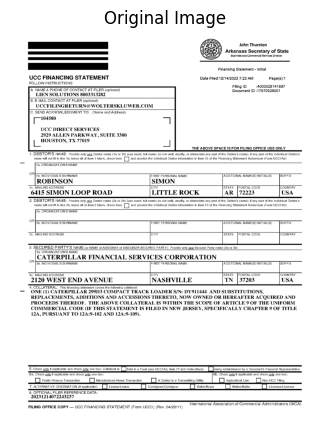

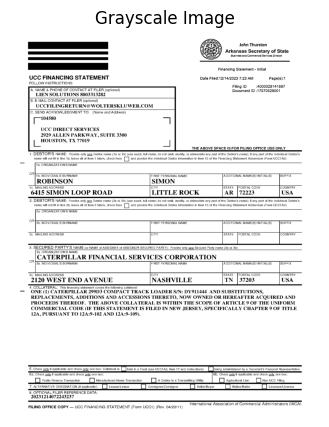

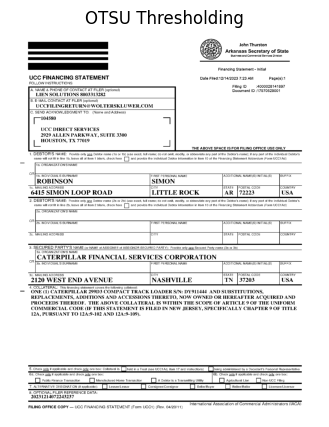

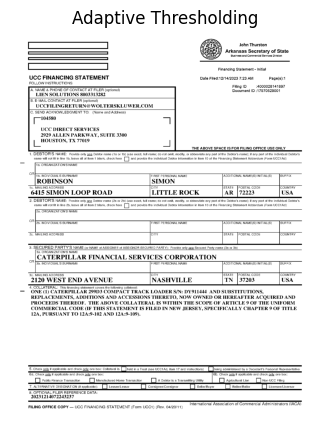

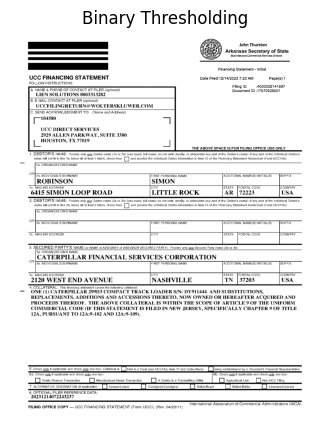

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def display_images(original, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(original, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Read the original image
image_path = '/content/4000028141897.tiff'
image = cv2.imread(image_path)

# Display original image
display_images(image, 'Original Image')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show grayscale image
display_images(gray, 'Grayscale Image')

# OTSU Thresholding
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
display_images(th_otsu, 'OTSU Thresholding')

# Adaptive Thresholding
th_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)  # Adjust block size and constant as needed
display_images(th_adaptive, 'Adaptive Thresholding')

# Simple Binary Thresholding
ret, th_binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
display_images(th_binary, 'Binary Thresholding')


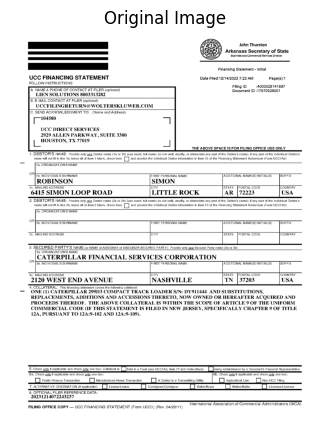

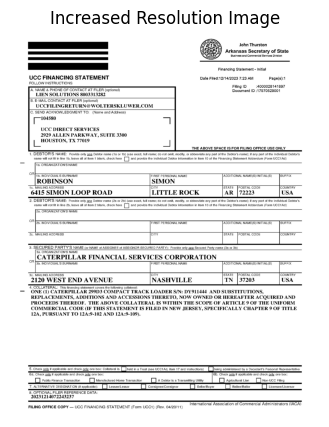

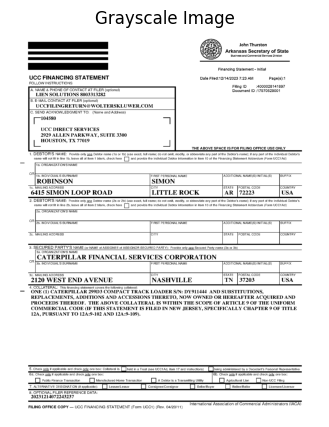

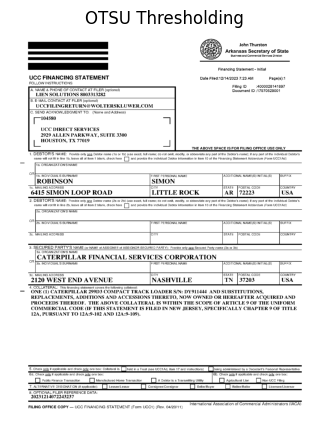

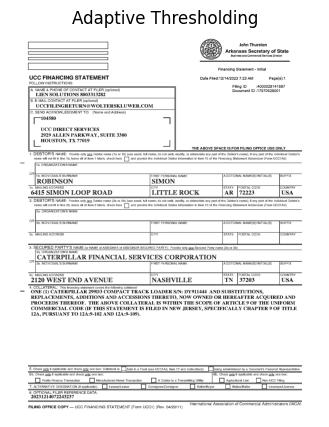

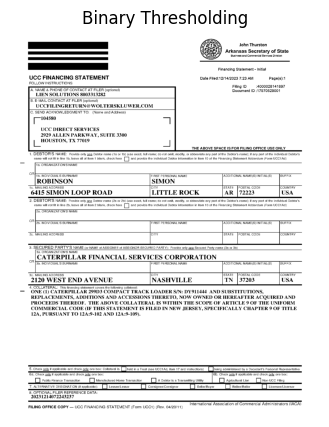

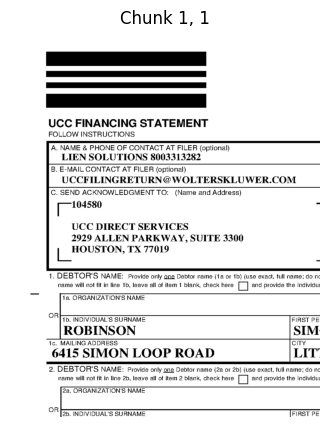

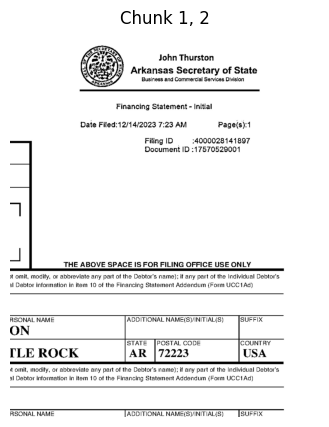

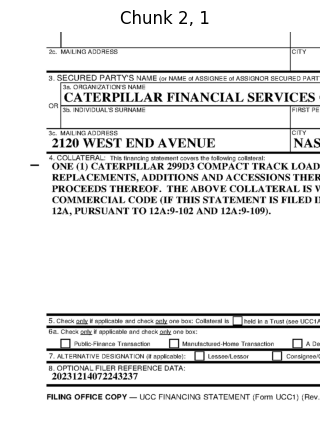

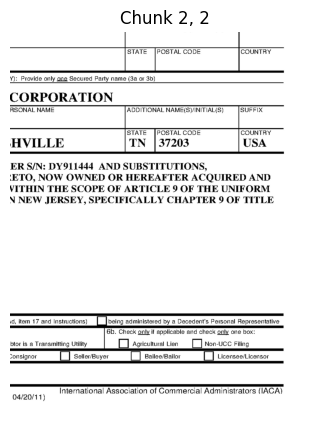

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def display_images(original, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(original, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def increase_resolution(image):
    # Upscale the image using INTER_CUBIC interpolation
    return cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

def chunk_image(image):
    # Assuming that the image can be divided into 4 equal parts (2x2 grid)
    h, w = image.shape[:2]
    chunks = []
    for i in range(2):
        for j in range(2):
            # Chunk coordinates
            x_start = j * (w // 2)
            x_end = (j + 1) * (w // 2)
            y_start = i * (h // 2)
            y_end = (i + 1) * (h // 2)
            chunk = image[y_start:y_end, x_start:x_end]
            chunks.append(chunk)
            display_images(chunk, f'Chunk {i + 1}, {j + 1}')
    return chunks

# Read the original image
image_path = '/content/4000028141897.tiff'
image = cv2.imread(image_path)

# Display original image
display_images(image, 'Original Image')

# Increase the resolution of the image
high_res_image = increase_resolution(image)
display_images(high_res_image, 'Increased Resolution Image')

# Convert to grayscale
gray = cv2.cvtColor(high_res_image, cv2.COLOR_BGR2GRAY)

# Show grayscale image
display_images(gray, 'Grayscale Image')

# OTSU Thresholding
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
display_images(th_otsu, 'OTSU Thresholding')

# Adaptive Thresholding
th_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)  # Adjust block size and constant as needed
display_images(th_adaptive, 'Adaptive Thresholding')

# Simple Binary Thresholding
ret, th_binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
display_images(th_binary, 'Binary Thresholding')

# Chunk the high-resolution image
chunks = chunk_image(high_res_image)
